# Import modules

In [ ]:
import os
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pprint import pprint
%matplotlib inline

In [ ]:
# mpl.font_manager._rebuild()
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'

# coverage around motif sites

In [ ]:
os.chdir('/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/TF/comparison/motif_coverage')

In [ ]:
%%bash
# not used
intersectBed -u -a ATF1.bed -b ~/fitCUTRUN/revision_1/analysis/TF/comparison/FRiP/union_peaks/ATF1_union_peaks.merged.bed > ATF1_wi_unionPeak.bed
intersectBed -u -a ELF1.bed -b ~/fitCUTRUN/revision_1/analysis/TF/comparison/FRiP/union_peaks/ELF1_union_peaks.merged.bed > ELF1_wi_unionPeak.bed
intersectBed -u -a ATF1.bed -b ~/fitCUTRUN/revision_1/analysis/TF/comparison/FRiP/union_peaks/ATF1_intersect_peaks.merged.bed > ATF1_wi_intersectPeak.bed
intersectBed -u -a ELF1.bed -b ~/fitCUTRUN/revision_1/analysis/TF/comparison/FRiP/union_peaks/ELF1_intersect_peaks.merged.bed > ELF1_wi_intersectPeak.bed


## ATF1

In [ ]:
bw_scan = True

import subprocess

name = 'around_ATF1_motif'
peak_type = 'none'
capture_regions_file = f'ATF1_wi_{peak_type}Peak.bed' if peak_type != 'none' else 'ATF1.bed'
resolution = 100
span = 2000
capture_points = int(2 * span / resolution + 1)
xticks = np.arange(-span, span + resolution, resolution)
bigwig_files = [
    'ATF1_1e5.bw',
    'ATF1_FlagCR_1e5.bw',
    'ATF1_wtCR_1e5.bw',
    'ATF1_ChIP.bw',
    'IgG_public_GSE120011.bw',
]
labels = [
    'FitCUT&RUN',
    'Flag-CUR&RUN',
    'CUR&RUN',
    'ChIP-seq',
    'IgG control',
]

cmd = f'''awk '{{print $1"\\t"$2-{span}-{resolution >> 1}"\\t"$3+{span}+{resolution >> 1}"\\t"$4"\\t"$5"\\t"$6}}' {capture_regions_file} > capture_regions.bed '''
print(subprocess.check_output(cmd, shell=True).decode(), end='')

capture_regions_file = 'capture_regions.bed'
bw_scan_cmd = f'/mnt/Storage/home/wangyiman/bin/utilities/getBigWigValue.py -n {name} -p 8 -s {capture_points} -m speed -b {capture_regions_file} --strand'

for bigwig_file in bigwig_files:
    bw_scan_cmd += f' -w {bigwig_file}'

if bw_scan:
    print(subprocess.check_output(bw_scan_cmd.split()).decode(), end='')


def get_bigwig_mean(bw_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bw_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold


signal = {}
for index, (bigwig_file, label) in enumerate(zip(bigwig_files, labels)):
    mean = get_bigwig_mean(bigwig_file)
    signal[label] = pd.read_csv(f'signal_{name}_siteprof{index+1}.gz',
                                sep='\t',
                                header=None,
                                index_col=None,
                                names=xticks) / mean
signal[labels[0]].head()

,-2000,-1900,-1800,-1700,-1600,-1500,-1400,-1300,-1200,-1100,...,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.121967,0.0,...,3.054104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


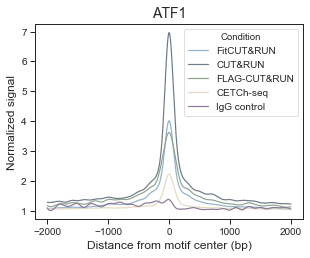

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):
    colors = ['#92B2CB', '#6F7B88', '#8DA58E', '#E2DBC2', '#8C7997']
    fig, ax = plt.subplots(figsize=(6.4 * .75, 4.8 * .75))
    i = 0
    for label in ['FitCUT&RUN','CUR&RUN','Flag-CUR&RUN','ChIP-seq','IgG control']:
        x = signal[labels[0]].columns
        xnew = np.linspace(x.min(), x.max(), 300) 
        spl = make_interp_spline(x, signal[label].mean(), k = 3)
        signal_smooth = spl(xnew)
        ax.plot(xnew, signal_smooth, label=label, color=colors[i])
        i += 1
        
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, ['FitCUT&RUN','CUT&RUN','FLAG-CUT&RUN','CETCh-seq','IgG control'], title="Condition")
    
    ax.set_xlabel('Distance from motif center (bp)')
    ax.set_ylabel('Normalized signal')
    ax.set_title('ATF1')
    fig.savefig(f'/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/figures/Supple_Fig2D_motif_cov_ATF1_{peak_type}.pdf', transparent=True)